In [1]:
import pandas as pd
import seaborn as sns
from pydci.log import enable_log, disable_log
from pydci.examples import lotka_volterra
import importlib
import itertools
from alive_progress import alive_bar
from pydci import PCAMUDProblem
from pydci.log import logger
import numpy as np
import pandas as pd


def solve_search(
    self,
    prob_args, 
    search_list,
    def_args = None,
    exp_thresh: float = 0.5,
    best_method: str = "closest",
):
    """
    Search through different iterations of solvign the PCA problem

    Thea idea of this method is, given a chunk of data, and a list of
    different iterative solve arguments, solve them and determine
    the "best" solution

    # TODO: Move this inside of Model class: self -> self

    Parameters
    ----------
    """

    am = ["closest", "min_kl", "max_kl"]
    if best_method not in am:
        msg = f"Unrecognized best method {best_method}. Allowed: {am}"
        raise ValueError(msg)
    if exp_thresh <= 0:
        msg = f"Expected ratio thresh must be a float > 0: {exp_thresh}"
        raise ValueError(msg)

    all_search_results = []
    all_results = []
    with alive_bar(
        len(search_list),
        title="Solving for different combinations",
        force_tty=True,
        receipt=True,
        length=40,
    ) as bar:
        for idx, args in enumerate(search_list):
            args.update(def_args if def_args is not None else {})

            # Solve -> Saves states in state dictionary
            prob = PCAMUDProblem(prob_args['samples'],
                                 prob_args['data'],
                                 self.measurement_noise,
                                 pi_in=prob_args['pi_in'])
                                 
            try:
                prob.solve_it(**args, state_extra={"search_index": idx})
            except ZeroDivisionError or KDEError as e:
                logger.error(f"Failed: Ill-posed problem: {e}")
                continue 
            except RuntimeError as r:
                if "No solution found within exp_thresh" in str(r):
                    logger.error(f"Failed: No solution in exp_thresh: {r}")
                    continue
                else:
                    raise r
            else:
                # ! What state do we need to whipe here to ensure back to original conditions of search on next iteration?
                # Store results per each iteration and final result
                # This will be erased the next iteration if we don't store it
                all_search_results.append(prob.it_results.copy())
                all_search_results[-1]["index"] = idx
                all_results.append(prob.result.copy())
                all_results[-1]["index"] = idx

            bar()

    # Parse DataFrame with results of mud estimations for each ts choice
    res_df = pd.concat(all_results)
    res_df["predict_delta"] = np.abs(res_df["e_r"] - 1.0)
    res_df["within_thresh"] = res_df["predict_delta"] <= exp_thresh
    res_df["closest"] = np.logical_and(
        res_df["predict_delta"]
        <= res_df[res_df["within_thresh"]]["predict_delta"].min(),
        res_df["within_thresh"],
    )
    res_df["max_kl"] = np.logical_and(
        res_df["kl"] >= res_df[res_df["within_thresh"]]["kl"].max(),
        res_df["within_thresh"],
    )
    res_df["min_kl"] = np.logical_and(
        res_df["kl"] <= res_df[res_df["within_thresh"]]["kl"].min(),
        res_df["within_thresh"],
    )

    # Set to best
    search_results = res_df
    all_search_results = pd.concat(all_search_results) # Has internal iterations for each try
    result = res_df[res_df[best_method]]

    if len(result) == 0:
        raise RuntimeError(f'No solution found within exp_thresh')
    else:
        # Re-solve Using Best
        best = PCAMUDProblem(prob_args['samples'],
                             prob_args['data'],
                             self.measurement_noise,
                             pi_in=prob_args['pi_in'])
        best.solve_it(**search_list[result['index'].values[0]])
    
    return {'best': best, 'search_results': search_results, 'all_search_results': all_search_results}

enable_log()

[07/17/23 13:35:46] INFO     Logger initialized                                                           ]8;id=552968;file:///Users/carlos/repos/pyDCI/src/pydci/log.py\log.py]8;;\:]8;id=500728;file:///Users/carlos/repos/pyDCI/src/pydci/log.py#78\78]8;;\

<loguru.logger handlers=[(id=1, level=20, sink=<RichHandler (NOTSET)>)]>

In [2]:
def parse_splits_list(config):
    splits_list = [{'pca_splits': i,
                    'pca_components': config['pca_components'],
                    'pca_mask': config['pca_mask'],
                    'exp_thresh': config['exp_thresh']}
                   for i in range(1, len(range(config['pca_mask']))%lvm.n_params)]
    return splits_list

def parse_mask_list(mask_max,
                    step_size=1,
                    pca_splits=1,
                    exp_thresh=1e20,
                    pca_components=[[0]]):
    mask_list = [{'pca_splits': pca_splits,
                 'pca_components': pca_components,
                 'pca_mask': range(i),
                 'exp_thresh': exp_thresh} for i in range(step_size, mask_max - 1, step_size)]
    return mask_list

def parse_pca_list(nc,
                   pca_splits=1,
                   exp_thresh=1e20,
                   pca_mask=None):
    pca_list = [{'pca_splits': pca_splits,
                 'pca_components': [list(range(i + 1))],
                 'pca_mask': pca_mask,
                 'exp_thresh': exp_thresh} for i in range(nc)
                if pca_mask is None or i < len(pca_mask)]
    return pca_list

In [4]:
def get_search_combinations(self,
                            data_idx=-1,
                            exp_thresh=1e20,
                            ):
    """
    """
    if len(self.data) == 0 or data_idx > len(self.data):
        raise ValueError(f"Invalid data_idx: {data_idx}. Data length: {len(self.data)}")
    df = self.data[data_idx]
    sampled_data = df[df['sample_flag']]
    n_data = len(sampled_data) *  self.n_states
    data_chunk_size = self.n_params if self.n_params <= n_data else n_data

    # * PCA component variations -> Dependent on sample size (and # of data points if <= n_params)
    # First choose # of principle components to use. 
    # Start with just doing all possible:  1->data_chunk_size.
    # TODO: Future -> Use sample size to determine how many components to use (dimenionalsity of problem)
    # * Data Mask -> What percent of total data to use
    # * Increasing chunks of data_chunk_size.
    search_list = [
        {
            'exp_thresh': exp_thresh,
            'pca_components': [list(range(i + 1))],
            'pca_mask': range(j),
            'pca_splits': k,
        }
        for i in range(data_chunk_size)
        for j in range(data_chunk_size, n_data, data_chunk_size)
        for k in range(1, (n_data + 1)%data_chunk_size + 1)
        if j/(k*data_chunk_size) >= 1.0 
    ]

    return search_list

# search_combs = get_search_combinations(lvm, data_idx=0)
# len(search_combs)

# Initialize Problem

In [5]:
lvm = lotka_volterra.LotkaVolterraModel(sample_ts=0.5)

# First Iteration

In [6]:
pi_in, samples = lvm.get_uniform_initial_samples(num_samples=100, scale=0.5)
f_res_1 = lvm.forward_solve(4, samples=samples)

[07/17/23 13:35:57] INFO     Drawing 100 from uniform at:                                              ]8;id=767147;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=203316;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#257\257]8;;\
                                     loc: [0.5   0.01  0.005 0.5  ]                                                
                                     scale: [1.   0.02 0.01 1.  ]                                                  

                    INFO     end_point: 4.0, [20.64983873 66.26176273]                                 ]8;id=364361;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py\Model.py]8;;\:]8;id=599609;file:///Users/carlos/repos/pyDCI/src/pydci/Model.py#173\173]8;;\

Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (2979.85


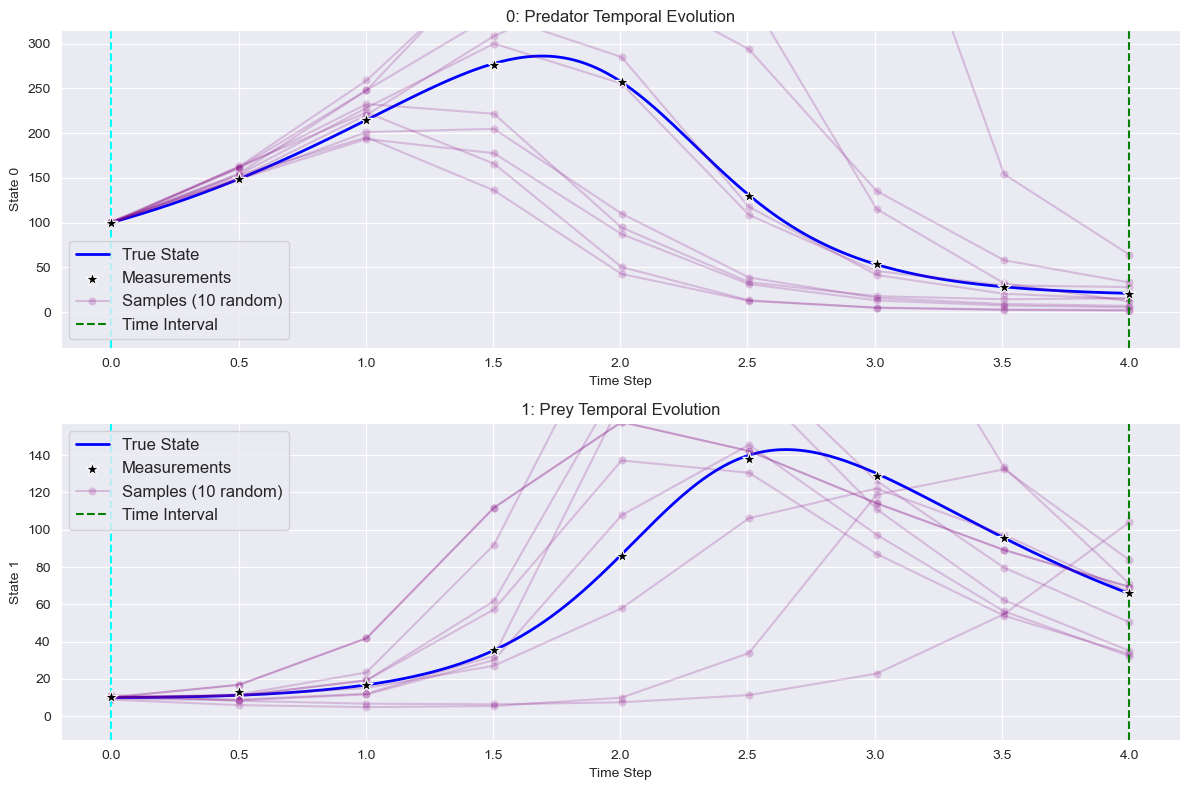

In [7]:
lvm.plot_states()

In [8]:
n_data = lvm.data[-1]['sample_flag'].sum()
mask_search = parse_mask_list(n_data,
                                step_size=lvm.n_params,
                                pca_splits=1,
                                exp_thresh=1e20, pca_components=[[0]])
full_search = list(itertools.chain.from_iterable([
    parse_pca_list(4, x['pca_splits'], x['exp_thresh'],
                x['pca_mask']) for x in mask_search]))
len(full_search)

4

In [9]:
disable_log()
prob_args = {'samples': f_res_1['samples'],
             'data': f_res_1['data'],
             'pi_in': pi_in}
search_res_1 = solve_search(lvm, prob_args, full_search, exp_thresh=1e20, best_method='max_kl')
search_res_1['search_results']

Solving for different combinations |                                        | ▁▃

Solving for different combinations |████████████████████████████████████████| 4/


,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl
0,1.000823,0.580210,1.379816,0.024645,0.009997,0.832511,28,[0],"range(0, 4)",0,0,0.000823,True,True,False,True
0,1.240803,2.999911,0.965980,0.016840,0.010567,0.749121,41,"[0, 1]","range(0, 4)",0,1,0.240803,True,False,False,False
0,1.334405,2.937273,0.943934,0.012524,0.011059,0.802307,19,"[0, 1, 2]","range(0, 4)",0,2,0.334405,True,False,False,False
0,1.461282,3.111821,0.943934,0.012524,0.011059,0.802307,19,"[0, 1, 2, 3]","range(0, 4)",0,3,0.461282,True,False,True,False


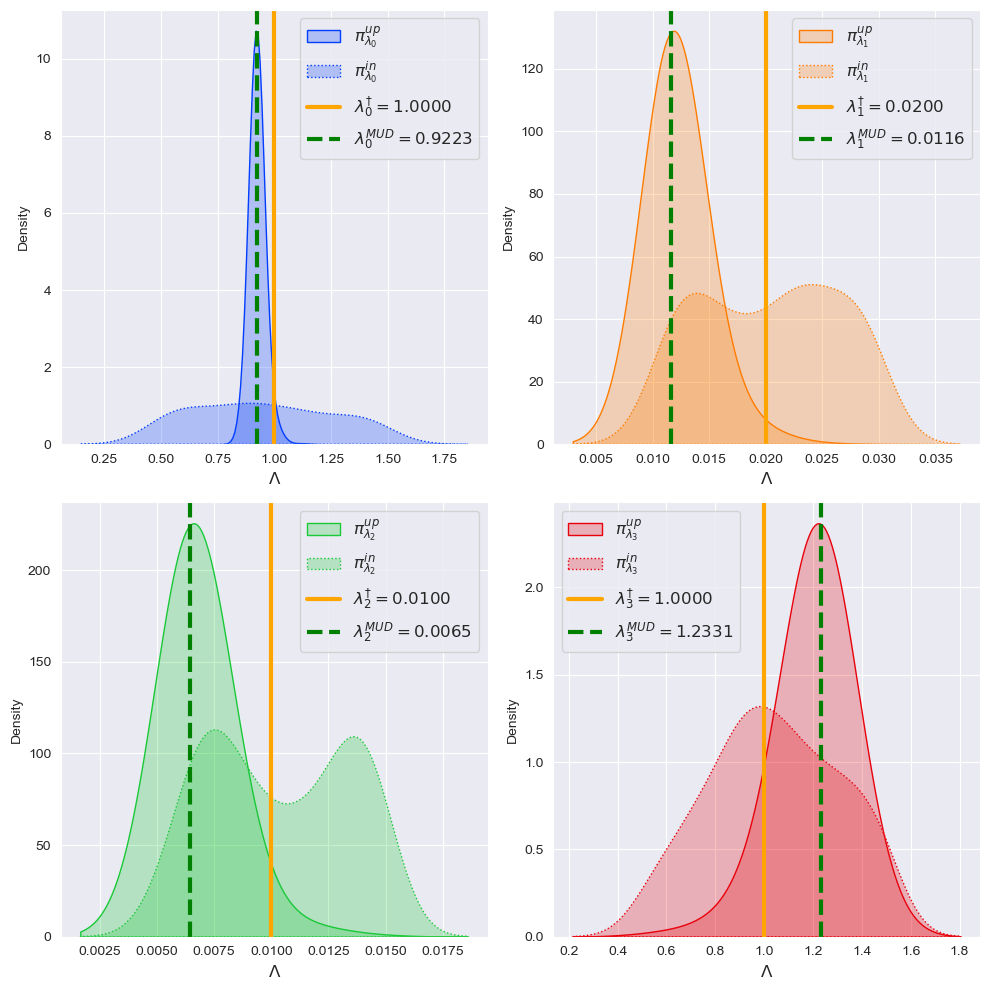

In [6]:
# search_res['best'].param_density_plots()
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    search_res_1['best'].plot_L(plot_mud=True, lam_true=[lvm.lam_true], param_idx=i, ax=ax)

# Second Iteration

In [7]:
samples_2 = search_res_1['best'].sample_dist(num_samples=100, dist='pi_up')

In [8]:
f_res_2 = lvm.forward_solve(12, samples=samples_2)

Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (928.42/


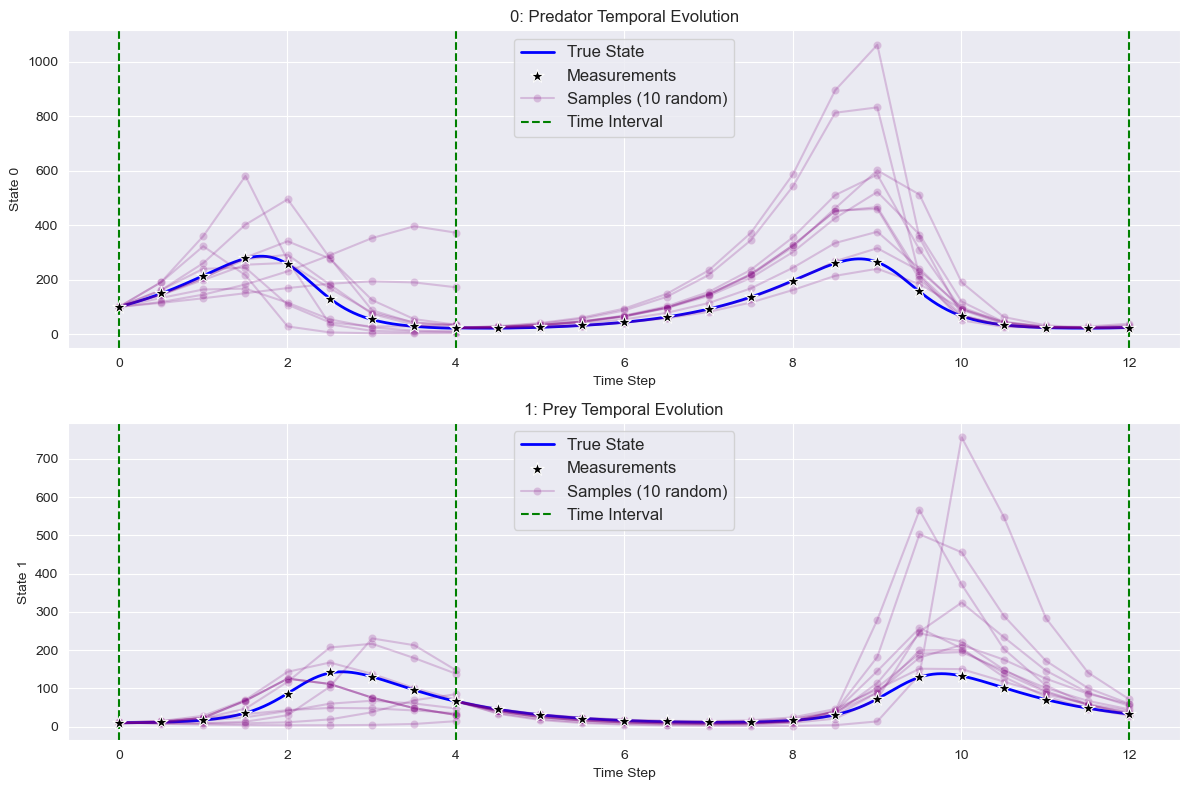

In [9]:
lvm.plot_states()

In [10]:
n_data = lvm.data[-1]['sample_flag'].sum()
mask_search = parse_mask_list(n_data,
                                step_size=lvm.n_params,
                                pca_splits=1,
                                exp_thresh=1e20, pca_components=[[0]])
full_search = list(itertools.chain.from_iterable([
    parse_pca_list(4, x['pca_splits'], x['exp_thresh'],
                x['pca_mask']) for x in mask_search]))
len(full_search)

12

In [11]:
disable_log()
prob_args = {'samples': f_res_2['samples'],
             'data': f_res_2['data'],
             'pi_in': search_res_1['best'].dists['pi_up']}
search_res_2 = solve_search(lvm, prob_args, full_search, exp_thresh=1e20, best_method='max_kl')
search_res_2['search_results']

Solving for different combinations |████████████████████████████████████████| 12


,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl
0,0.873730,4.492544,0.904972,0.016809,0.010747,0.982656,0,[0],"range(0, 4)",0,0,0.126270,True,False,False,True
0,0.282651,6.469138,0.949220,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 4)",0,1,0.717349,True,False,True,False
0,0.181803,5.766700,0.949220,0.019222,0.009466,1.028548,57,"[0, 1, 2]","range(0, 4)",0,2,0.818197,True,False,False,False
0,0.104758,5.384752,0.949220,0.019222,0.009466,1.028548,57,"[0, 1, 2, 3]","range(0, 4)",0,3,0.895242,True,False,False,False
0,0.926678,4.596656,0.948462,0.014435,0.009835,0.923638,93,[0],"range(0, 8)",0,4,0.073322,True,True,False,False
0,1.616029,6.094260,0.949220,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 8)",0,5,0.616029,True,False,False,False
0,1.109965,5.836105,0.949220,0.019222,0.009466,1.028548,57,"[0, 1, 2]","range(0, 8)",0,6,0.109965,True,False,False,False
0,0.045452,5.156704,0.949220,0.019222,0.009466,1.028548,57,"[0, 1, 2, 3]","range(0, 8)",0,7,0.954548,True,False,False,False
0,0.785414,5.564688,0.949220,0.019222,0.009466,1.028548,57,[0],"range(0, 12)",0,8,0.214586,True,False,False,False
0,0.222061,5.453645,0.949220,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 12)",0,9,0.777939,True,False,False,False


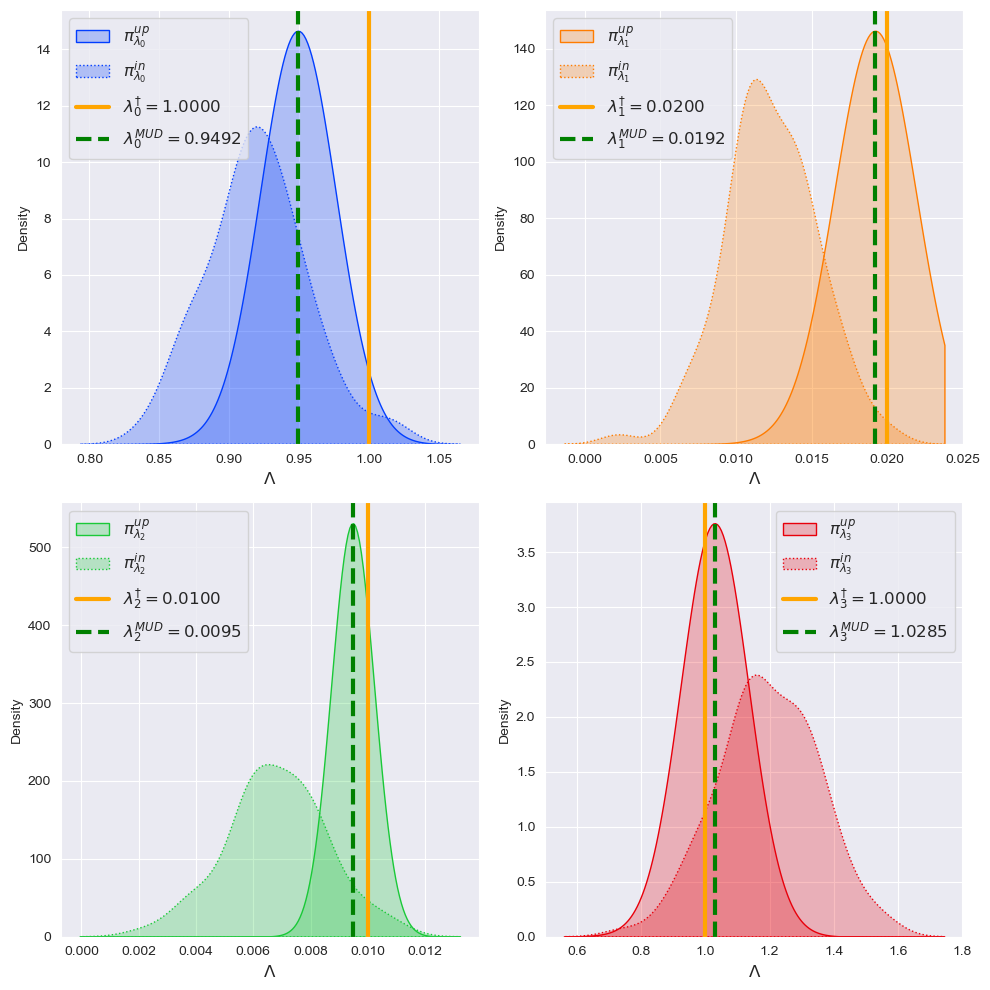

In [12]:
# search_res['best'].param_density_plots()
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    search_res_2['best'].plot_L(plot_mud=True, lam_true=[lvm.lam_true], param_idx=i, ax=ax)

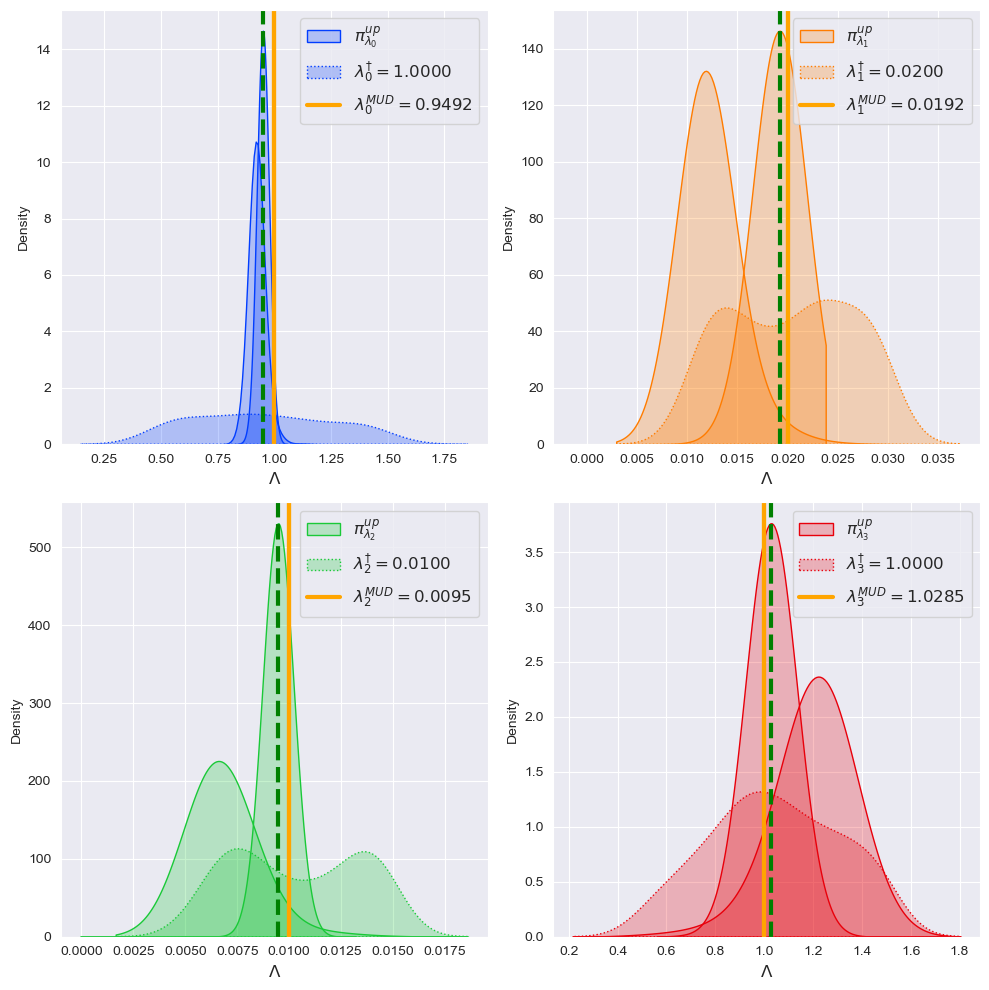

In [13]:
# search_res['best'].param_density_plots()
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    search_res_1['best'].plot_L(plot_mud=False, lam_true=[lvm.lam_true], param_idx=i, ax=ax)
    search_res_2['best'].plot_L(plot_mud=True, lam_true=[lvm.lam_true], param_idx=i, ax=ax, plot_initial=False)

# Third Iteration

In [14]:
samples_3 = search_res_2['best'].sample_dist(num_samples=100, dist='pi_up')

In [15]:
f_res_3 = lvm.forward_solve(24, samples=samples_3)

Solving model sample set: |████████████████████| 100/100 [100%] in 0.0s (1775.96


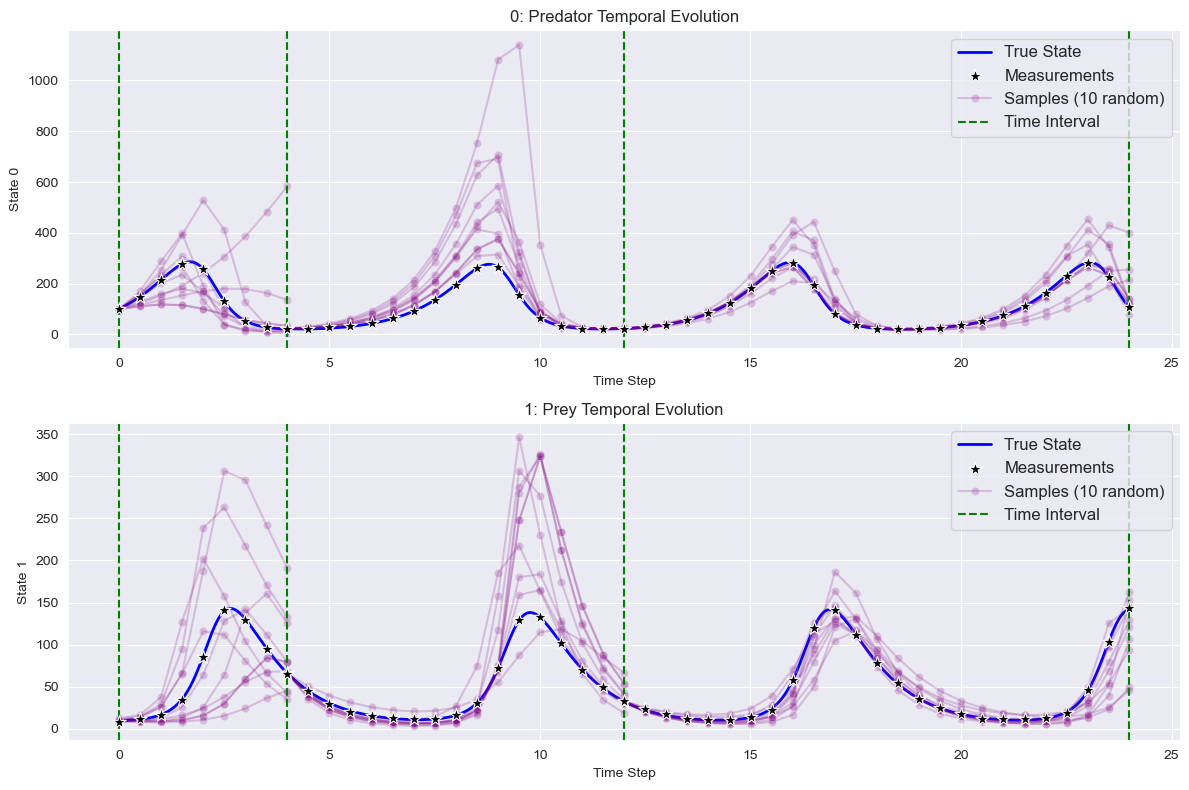

In [16]:
lvm.plot_states()

In [17]:
n_data = lvm.data[-1]['sample_flag'].sum()
mask_search = parse_mask_list(n_data,
                                step_size=lvm.n_params,
                                pca_splits=1,
                                exp_thresh=1e20, pca_components=[[0]])
full_search = list(itertools.chain.from_iterable([
    parse_pca_list(4, x['pca_splits'], x['exp_thresh'],
                x['pca_mask']) for x in mask_search]))
len(full_search)

20

In [18]:
disable_log()
prob_args = {'samples': f_res_2['samples'],
             'data': f_res_2['data'],
             'pi_in': search_res_2['best'].dists['pi_up']}
search_res_3 = solve_search(lvm, prob_args, full_search, exp_thresh=1e20, best_method='max_kl')
search_res_3['search_results']

Solving for different combinations |████████████████████████████████████████| 20


,e_r,kl,lam_MUD_0,lam_MUD_1,lam_MUD_2,lam_MUD_3,MUD_idx,pca_components,pca_mask,i,index,predict_delta,within_thresh,closest,max_kl,min_kl
0,8.737295e-01,4.492544,0.94922,0.019222,0.009466,1.028548,57,[0],"range(0, 4)",0,0,0.126270,True,False,False,True
0,2.826505e-01,6.469138,0.94922,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 4)",0,1,0.717349,True,False,True,False
0,1.818030e-01,5.766700,0.94922,0.019222,0.009466,1.028548,57,"[0, 1, 2]","range(0, 4)",0,2,0.818197,True,False,False,False
0,1.047577e-01,5.384752,0.94922,0.019222,0.009466,1.028548,57,"[0, 1, 2, 3]","range(0, 4)",0,3,0.895242,True,False,False,False
0,9.266777e-01,4.596656,0.94922,0.019222,0.009466,1.028548,57,[0],"range(0, 8)",0,4,0.073322,True,True,False,False
0,1.616029e+00,6.094260,0.94922,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 8)",0,5,0.616029,True,False,False,False
0,1.109965e+00,5.836105,0.94922,0.019222,0.009466,1.028548,57,"[0, 1, 2]","range(0, 8)",0,6,0.109965,True,False,False,False
0,4.545152e-02,5.156704,0.94922,0.019222,0.009466,1.028548,57,"[0, 1, 2, 3]","range(0, 8)",0,7,0.954548,True,False,False,False
0,7.854143e-01,5.564688,0.94922,0.019222,0.009466,1.028548,57,[0],"range(0, 12)",0,8,0.214586,True,False,False,False
0,2.220610e-01,5.453645,0.94922,0.019222,0.009466,1.028548,57,"[0, 1]","range(0, 12)",0,9,0.777939,True,False,False,False


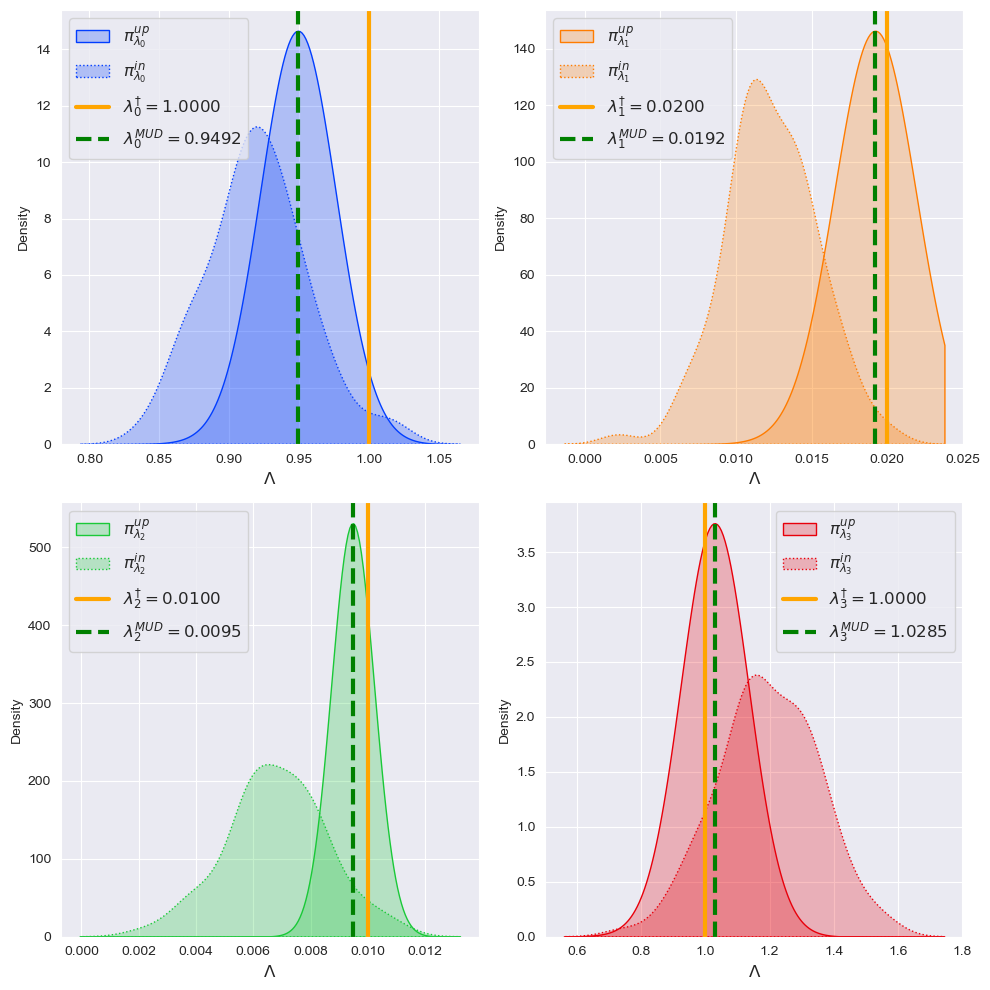

In [19]:
# search_res['best'].param_density_plots()
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    search_res_3['best'].plot_L(plot_mud=True, lam_true=[lvm.lam_true], param_idx=i, ax=ax)

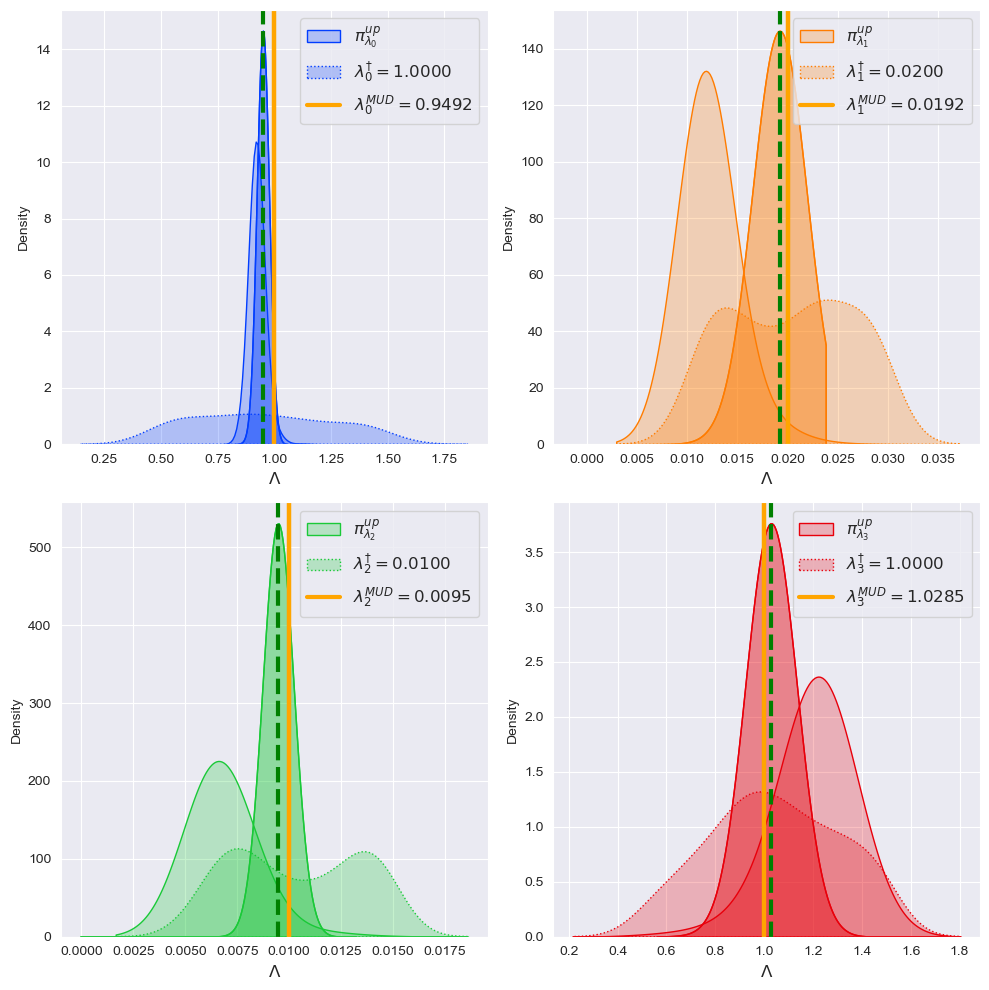

In [20]:
# search_res['best'].param_density_plots()
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    search_res_1['best'].plot_L(plot_mud=False, lam_true=[lvm.lam_true], param_idx=i, ax=ax)
    search_res_2['best'].plot_L(plot_mud=False, lam_true=[lvm.lam_true], param_idx=i, ax=ax, plot_initial=False)
    search_res_3['best'].plot_L(plot_mud=True, lam_true=[lvm.lam_true], param_idx=i, ax=ax, plot_initial=False)

# Final Samples

In [21]:
samples_f = search_res_3['best'].sample_dist(num_samples=100, dist='pi_up')

In [22]:
pf_final = lvm.forward_solve(40, samples=samples_f)

Solving model sample set: |                    | ▁▃▅ 0/100 [0%] in 0s (~0s, 0.0/

Solving model sample set: |████████████████████| 100/100 [100%] in 0.1s (875.86/


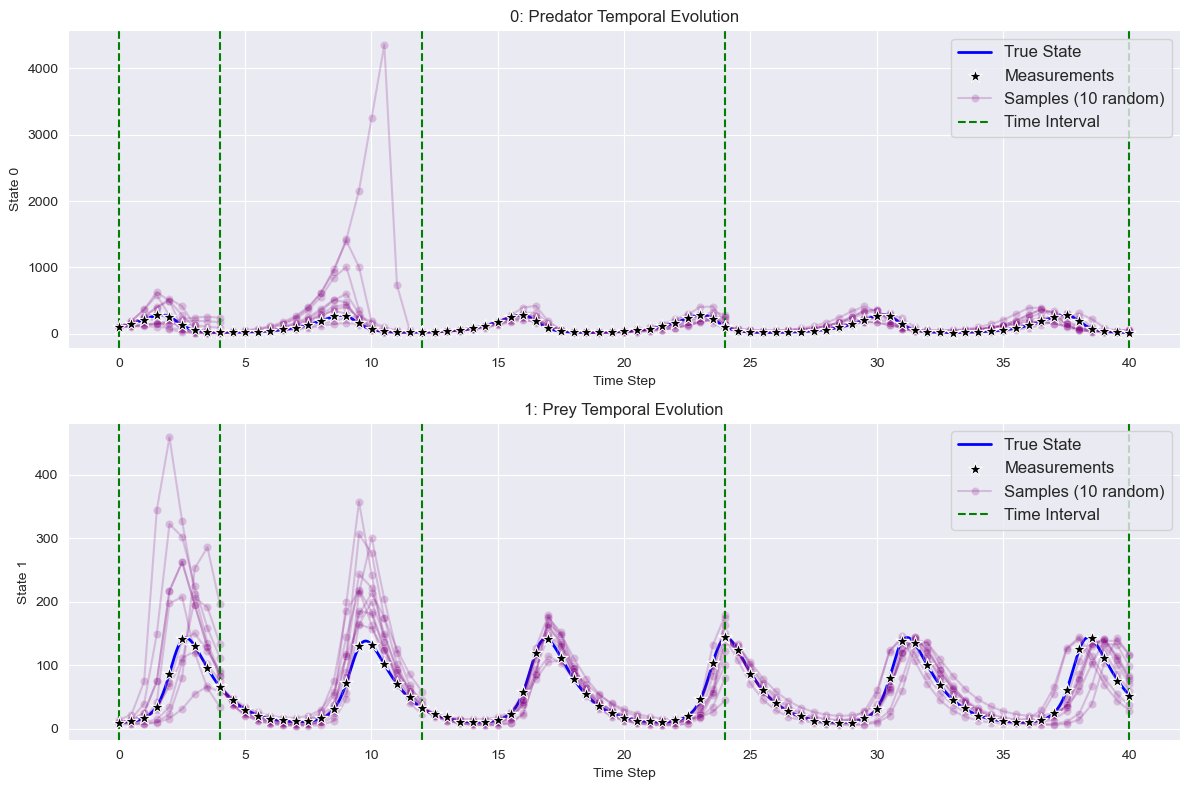

In [23]:
lvm.plot_states()